<a href="https://colab.research.google.com/github/jayantdahiya/Deep-Facial-Recognition/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import uuid

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
POS_PATH = os.path.join('./data', './positive')
NEG_PATH = os.path.join('./data', './negative')
ANC_PATH = os.path.join('./data', './anchor')

In [4]:
# for directory in os.listdir('lfw'):
#   for file in os.listdir('lfw', directory):
#     EX_PATH = os.path.join('lfw', directory, file)
#     NEW_PATH = os.path.join(NEG_PATH, file)
#     os.replace(EX_PATH, NEW_PATH)

In [5]:
#Getting image directory
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)


2022-01-11 22:04:07.748078: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
dir_test = anchor.as_numpy_iterator()

In [7]:
print(dir_test.next())

b'./data/./anchor/7266a26e-70da-11ec-882c-cae6cca50a85.jpg'


In [8]:
#function to decode image with values between 0 and 1
def preprocess(file_path):
  byte_img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(byte_img)
  img = tf.image.resize(img, (100,100))
  img = img/255.0
  return img

In [9]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [10]:
sample = data.as_numpy_iterator()
example = sample.next()
example

(b'./data/./anchor/744dd71e-70da-11ec-882c-cae6cca50a85.jpg',
 b'./data/./positive/8ce18f50-70da-11ec-882c-cae6cca50a85.jpg',
 1.0)

In [11]:
def preprocess_twin(input_img, validation_img, label):
  return(preprocess(input_img), preprocess(validation_img), label)

In [12]:
res = preprocess_twin(*example)

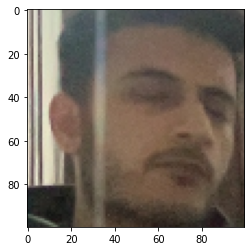

In [13]:
plt.imshow(res[1])

In [14]:
#Data pipeline 
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [15]:
#Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [16]:
#testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [17]:
def make_embedding():
  inp = Input(shape=(100,100,3), name='input image')

  #First block
  c1 = Conv2D(64, (10,10), activation='relu')(inp)
  m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

  #Second block
  c2 = Conv2D(128, (7,7), activation='relu')(m1)
  m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

  #Third block
  c3 = Conv2D(128, (4,4), activation='relu')(m2)
  m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

  #Final Embedding block
  c4 = Conv2D(256, (4,4), activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1)

  return Model(inputs=[inp], outputs=[d1], name='embedding')

In [18]:
embedding = make_embedding()

In [19]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [20]:
#Siamese L1 Distance class
class L1Dist(Layer):
  
  #Init method - inheritance
  def __init__(self, **kwargs):
    super().__init__()

  #Similarity calculation
  def call(self, input_embedding, validation_embedding):
    return tf.math.abs(input_embedding - validation_embedding)

In [21]:
l1 = L1Dist()

In [22]:
def make_siamese_model():

  #Anchor img input into the network
  input_img = Input(name='input_img', shape=(100,100,3))

  #Validation img in the network
  validation_img = Input(name='validation_img', shape=(100,100,3))

  #Combine siamese distance components
  siamese_layer = L1Dist()
  siamese_layer._name = 'distance'
  distances = siamese_layer(embedding(input_img), embedding(validation_img))

  #classification layer
  classifier = Dense(1, activation='sigmoid')(distances)

  return Model(inputs=[input_img, validation_img], outputs=classifier, name='Siamese_Network')

In [23]:
siamese_model = make_siamese_model()

In [24]:
#Loss function
binary_cross_loss = tf.losses.BinaryCrossentropy()
#Optimizer
opt = tf.keras.optimizers.Adam(1e-4)

In [25]:
# Creating Checkpoints
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

In [26]:
#Training func
@tf.function
def train_step(batch):
  with tf.GradientTape() as tape:
    #Get anchor and positive/negative images
    X = batch[:2]
    #Get label
    Y = batch[2]

    #Forward pass
    yhat = siamese_model(X, training=True)
    #calculate loss
    loss = binary_cross_loss(Y, yhat)
  print(loss)

  #Calculate gradient
  grad = tape.gradient(loss, siamese_model.trainable_variables)

  #Calculate updated weights and apply to siamese model
  opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

  #Return loss
  return loss



In [27]:
#Training loop
def train(data, EPOCHS):
  #loop through epochs
  for epoch in range(1, EPOCHS+1):
    print('\n Epoch {}/{}'.format(epoch,EPOCHS))
    progbar = tf.keras.utils.Progbar(len(data))

    #loop through each batch
    for idx, batch in enumerate(data):
      #Run train step
      train_step(batch)
      progbar.update(idx+1)

      #Save Checkpoints
      if epoch % 10 ==0:
        checkpoint.save(file_prefix=checkpoint_prefix)

In [28]:
#Training the data
# EPOCHS = 50
# train(train_data, EPOCHS)

In [29]:
from tensorflow.keras.metrics import Precision, Recall

In [30]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [31]:
y_hat = siamese_model.predict([test_input, test_val])

In [32]:
y_hat

array([[0.49854547],
       [0.49911436],
       [0.49903694],
       [0.4976598 ],
       [0.49988276],
       [0.49916396],
       [0.49619603],
       [0.49952403],
       [0.4998807 ],
       [0.49818903],
       [0.49836287],
       [0.50009155],
       [0.49850872],
       [0.49955598],
       [0.49920568],
       [0.4998694 ]], dtype=float32)

In [33]:
[1 if prediction>0.5 else 0 for prediction in y_hat]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [34]:
y_true

array([1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1.],
      dtype=float32)

In [35]:
#Creating metirc object
m = Recall()
#calculating recall value
m.update_state(y_true, y_hat)
#Return recall result
m.result().numpy()

0.125

In [36]:
#Creating metirc object
m = Precision()
#calculating recall value
m.update_state(y_true, y_hat)
#Return recall result
m.result().numpy()

1.0

In [37]:
siamese_model.save('siamesemodel.h5')

In [38]:
#Reload model
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [39]:
model.predict([test_input, test_val])

array([[0.49854547],
       [0.49911436],
       [0.49903694],
       [0.4976598 ],
       [0.49988276],
       [0.49916396],
       [0.49619603],
       [0.49952403],
       [0.4998807 ],
       [0.49818903],
       [0.49836287],
       [0.50009155],
       [0.49850872],
       [0.49955598],
       [0.49920568],
       [0.4998694 ]], dtype=float32)

In [40]:
def verify(model, detection_threshold, verification_threshold):
    #build results array
    results = []
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data','verification_images',image))
        
        #Make predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        
    #Dectection threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    #Verification threshold: Proportion of positive predictions/ total positive samples
    verification = detection/ len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results, verified

In [42]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[420:420+250,500:500+250]
    
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data','input_images','input_image.jpg'), frame)
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

False
False
False
True
False
False
